### Methods

In this study, our goal was to estimate the prevalence of Autism Spectrum Disorder (ASD) stratified by Canadian province, age group, and sex. To this end, we utilized a Bayesian hierarchical model, which allowed us to estimate province-specific prevalence while accounting for variations between provinces, sex, and age groups.

We initiated our analysis by setting hyperpriors for the model intercepts, representing the group-level effects. The intercepts follow a normal distribution with mean 0 and standard deviation 10. A Half-Cauchy distribution was used to account for potential skewness in the data, with a scale parameter set to 1.

Random effects for each province were modelled with a normal distribution with the mean and standard deviation parameters defined by the hyperpriors. Additionally, fixed effects for sex and age group were integrated into the model. For sex, we began with a prior belief that males have four times higher odds for ASD, and for age group, we assumed a decrease in ASD prevalence with age.

The expected prevalence of ASD was calculated on a logit scale as the sum of the province-specific intercept and the fixed effects for age group and sex. This expected value was then converted back to its original scale using an inverse logit function.

The likelihood function was defined using a binomial distribution with the total population size as the number of trials and the estimated prevalence as the probability of success. The observed data were the number of individuals diagnosed with ASD.

#### Analysis
Subsequent to the model specification, we sampled from the posterior distribution using the No-U-Turn Sampler (NUTS), a variant of Hamiltonian Monte Carlo sampling that self-tunes. We set the model to run for a number of samples after an equal number of tuning steps. Our target acceptance rate was set to ensure efficient exploration of the parameter space. We initialized the sampling with a method that perturbs the starting point of the chains and adapts the mass matrix based on the variance of the tuning samples. This approach aids in avoiding local maxima in the posterior landscape and ensures convergence. To expedite computation, we parallelized the chains on multiple cores.

We then sampled from the posterior predictive distribution, generating predictions based on the posterior distributions of the model parameters. We focused on generating samples for the likelihood and the prevalence estimates.

#### Model Diagnostics

For model diagnostics, we visually inspected the mixing and convergence of our Markov chains using trace plots. Autocorrelation plots were used to examine the level of autocorrelation in the chains. A statistical summary of the posterior distributions was also obtained, including the mean, standard deviation, and highest posterior density intervals.

<b>Table</b>: Technical Details of the Bayesian Model
<br>
| Variable      | Description                                                                                   |
|:-------------|:--------------------------------------------------------------------------------------------- |
| mu_a | Normal hyperprior for the intercepts. Mean = 0, standard deviation = 10. |
| sigma_a | Half-Cauchy hyperprior for the intercepts. Scale parameter (beta) = 1. |
| a | Province random effect. Normal distribution with mean = mu_a and standard deviation = sigma_a. |
| b_sex | Fixed effect for sex. Normal distribution with mean = log(4) and standard deviation = 1. This represents the prior belief that males have 4 times higher odds for ASD. |
| b_age_raw | Fixed effect for age group. Normal distribution with mean = log(0.95) and standard deviation = 0.5. This assumes a decrease in ASD prevalence with age. |
| rho_est_logit | Expected ASD prevalence on a logit scale. It's calculated as the sum of the province-specific intercept, the fixed effects for age group, and sex. |
| rho_est | Expected ASD prevalence in the original scale. It's calculated using the inverse logit function on rho_est_logit. |
| y_like | Likelihood function. Binomial distribution with the total population size as the number of trials and the estimated prevalence as the probability of success. |
| trace | Draws samples from the posterior distribution of the model using No-U-Turn Sampler (NUTS). It runs for 10,000 samples after tuning with an additional 10,000 tuning steps, targeting an acceptance rate of 0.9. |
| post_pred | Draws samples from the posterior predictive distribution of the model. It generates predictions based on the posterior distributions of the "y_like" and "rho_est" parameters. |


#### Step 1:  Import required libraries

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.preprocessing import LabelEncoder
import arviz as az
import multiprocessing
from scipy.special import logit
from scipy.special import expit

In [2]:
data2=pd.read_csv('ASD Dataset.csv')

In [3]:
# Define bins and labels
bins = [18, 20, 25, 30,35,40,45,50,55,60,65,70,75,80,85, np.inf]
labels = ['18-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']

# Create a new column 'age_group' based on 'age' column
data2['age_group'] = pd.cut(data2['age'], bins=bins, labels=labels, right=False)

In [4]:
prov_age_sex=data2[['province','age_group','sex','population','gamma_adj']].groupby(['province', 'age_group', 'sex']).sum().reset_index()
prov_age_sex['rho_adj']=prov_age_sex['gamma_adj']/prov_age_sex['population']

prov_age_sex.to_csv('ASD by Province, Age, and Sex.csv', index=False)

In [5]:
# Convert categorical variables to integer indices
prov_age_sex['province'] = prov_age_sex['province'].astype('category')
prov_age_sex['province_cat'] = prov_age_sex['province'].cat.codes
n_provinces = len(prov_age_sex['province'].cat.categories)

prov_age_sex['age_group'] = prov_age_sex['age_group'].astype('category')
prov_age_sex['age_group_cat'] = prov_age_sex['age_group'].cat.codes

n_age_groups = len(prov_age_sex['age_group'].cat.categories)

prov_age_sex['sex'] = prov_age_sex['sex'].astype('category')
prov_age_sex['sex_cat'] = prov_age_sex['sex'].cat.codes

# Transform rho_adj to logit scale
prov_age_sex['logit_rho_adj'] = logit(prov_age_sex['rho_adj'])

# Prior beliefs
prior_mean = logit(0.02)  # Logit of 2%
prior_std_dev = 0.06  # This is an assumption based on Deitz simulation interval

# Take the log of the population size that will be used as an offset
prov_age_sex['log_population'] = np.log(prov_age_sex['population'])

In [6]:
prov_age_sex.head()

,province,age_group,sex,population,gamma_adj,rho_adj,province_cat,age_group_cat,sex_cat,logit_rho_adj,log_population
0,Alberta,18-19,Female,49680.0,554.602268,0.011163,0,0,0,-4.483880,10.813358
1,Alberta,18-19,Male,52128.0,1884.554847,0.036152,0,0,1,-3.283188,10.861458
2,Alberta,20-24,Female,132465.0,1471.406531,0.011108,0,1,0,-4.488930,11.794074
3,Alberta,20-24,Male,143100.0,5125.843052,0.035820,0,1,1,-3.292771,11.871299
4,Alberta,25-29,Female,155695.0,1715.995606,0.011022,0,2,0,-4.496823,11.955654


Below, we are performing a tuning phase (burn-in) of 10,000 samples. After this, we draw 10,000 samples from the posterior distribution.

<b>NOTE</b>: I did not apply thinning as Deitz et al. did for their analysis. From my understanding, thinning is sometimes used in Markov Chain Monte Carlo (MCMC) methods to reduce autocorrelation in the samples. However, it's not always necessary and can lead to discarding potentially useful samples.

In [7]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sigma=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    
    # Province random effect
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_provinces)
    
    # Fixed effects for sex and age group
    b_sex = pm.Normal('b_sex', mu=np.log(4), sigma=1)  # Assuming prior belief of 4 times higher odds for males
    b_age_raw = pm.Normal('b_age_raw', mu=np.log(0.95), sigma=0.5, shape=n_age_groups)  # Assuming decrease with age

    # Expected value on logit scale
    rho_est_logit = a[prov_age_sex['province_cat']] + b_age_raw[prov_age_sex['age_group_cat']] + b_sex*prov_age_sex['sex_cat']

    # Convert expected value back to original scale
    rho_est = pm.Deterministic('rho_est', pm.math.invlogit(rho_est_logit))

    # Likelihood
    y_like = pm.Binomial('y_like', n=prov_age_sex['population'], p=rho_est, observed=prov_age_sex['gamma_adj'])


In [8]:
n_cores = 16 #16 cores

# 'with' context manager is used with the model instance to perform operations within the context of this model
with hierarchical_model:
    # The 'pm.sample' function is used to draw samples from the posterior distribution of the model. 
    # 'draws=10000' is the number of samples drawn after tuning.
    # 'tune=10000' refers to the number of iterations used for tuning, i.e., the number of burn-in samples that are not included in the final trace.
    # 'target_accept=0.9' is the target acceptance probability for the Metropolis-Hastings or Hamiltonian Monte Carlo sampling methods.
    # 'init="auto"' is the initialization method used to start the sampling. Here 'jitter+adapt_diag' is being used.
    # 'cores=n_cores' is the number of chains to be sampled in parallel. Here, n_cores is the maximum number of available CPU cores.
    trace = pm.sample(draws=10000, tune=10000, init="auto",  chains= 8, cores=n_cores, step=[pm.NUTS(target_accept=0.90,max_treedepth=15)])

    # 'pm.sample_posterior_predictive' generates samples from the posterior predictive distribution, given the sampled trace.
    # 'var_names=["rho_adj_est"]' specifies that we only want to generate samples for the "rho_adj_est" variable.
    post_pred = pm.sample_posterior_predictive(trace, var_names=["y_like",'rho_est'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 16 jobs)
NUTS: [mu_a, sigma_a, a, b_sex, b_age_raw]


Sampling 8 chains for 10_000 tune and 10_000 draw iterations (80_000 + 80_000 draws total) took 1134 seconds.
Sampling: [y_like]


In [9]:
df=pm.summary(trace)
# df.to_csv('trace_summary_Normal2.csv')
df.to_csv('trace_summary_Binomial.csv')

In [10]:
post_pred_data = post_pred["posterior_predictive"]["rho_est"].values

# Reshape the data to merge the chains and samples
post_pred_data_reshaped = post_pred_data.reshape(-1, post_pred_data.shape[-1])

# Compute the mean prevalence estimate for each data point
mean_prevalence = post_pred_data_reshaped.mean(axis=0)

# Compute the 95% HPDI for each data point
hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)

# Create a DataFrame with the results
prevalence_df_rho = pd.DataFrame({
    "Estimated Prevalence": mean_prevalence,
    "Lower HPDI Prevalence": hpd_interval[:, 0],
    "Upper HPDI Prevalence": hpd_interval[:, 1],
})

C:\Users\Admin\AppData\Local\Temp\ipykernel_5320\3298605790.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)


In [11]:
prevalence_df_rho[0:30]

,Estimated Prevalence,Lower HPDI Prevalence,Upper HPDI Prevalence
0,0.010429,0.010255,0.010600
1,0.036455,0.035901,0.037024
2,0.010367,0.010242,0.010493
3,0.036245,0.035846,0.036631
4,0.010227,0.010104,0.010348
5,0.035767,0.035392,0.036147
6,0.010078,0.009960,0.010201
7,0.035260,0.034880,0.035633
8,0.009898,0.009780,0.010018
9,0.034648,0.034273,0.035018


In [12]:
post_pred_data = post_pred["posterior_predictive"]["y_like"].values

# Reshape the data to merge the chains and samples
post_pred_data_reshaped = post_pred_data.reshape(-1, post_pred_data.shape[-1])

# Compute the mean prevalence estimate for each data point
mean_prevalence = post_pred_data_reshaped.mean(axis=0)

# Compute the 95% HPDI for each data point
hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)

# Create a DataFrame with the results
prevalence_df_y = pd.DataFrame({
    "Estimated Cases": mean_prevalence,
    "Lower HPDI Cases": hpd_interval[:, 0],
    "Upper HPDI Cases": hpd_interval[:, 1],
})

C:\Users\Admin\AppData\Local\Temp\ipykernel_5320\1154163632.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)


In [13]:
prevalence_df_y[0:30]

,Estimated Cases,Lower HPDI Cases,Upper HPDI Cases
0,518.149863,471.0,561.0
1,1900.322512,1810.0,1987.0
2,1373.449388,1296.0,1444.0
3,5186.604038,5033.0,5331.0
4,1592.262788,1513.0,1672.0
5,5901.400750,5741.0,6062.0
6,1758.316288,1672.0,1840.0
7,6370.014038,6199.0,6534.0
8,1725.889825,1639.0,1806.0
9,6136.212363,5968.0,6297.0


In [14]:
df=pd.concat([prov_age_sex, prevalence_df_rho, prevalence_df_y], axis=1)
df.to_csv('ASD Prevalence from Bayesian Analysis - Binomial Distribution.csv')

HPDI stands for Highest Posterior Density Interval. It is a credible interval (or a type of interval estimate) that gives us a range of values within which an unknown parameter (like the mean or variance) lies with a certain degree of belief (usually 95% or 99%).

In Bayesian statistics, the HPDI is a way of summarizing the posterior distribution of a parameter. For a 95% HPDI, you can say "Given the observed data and our prior beliefs, there's a 95% probability that the true value of the parameter is within this interval."

array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_sex'}>,
        <Axes: title={'center': 'b_sex'}>],
       [<Axes: title={'center': 'b_age_raw'}>,
        <Axes: title={'center': 'b_age_raw'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'rho_est'}>,
        <Axes: title={'center': 'rho_est'}>]], dtype=object)

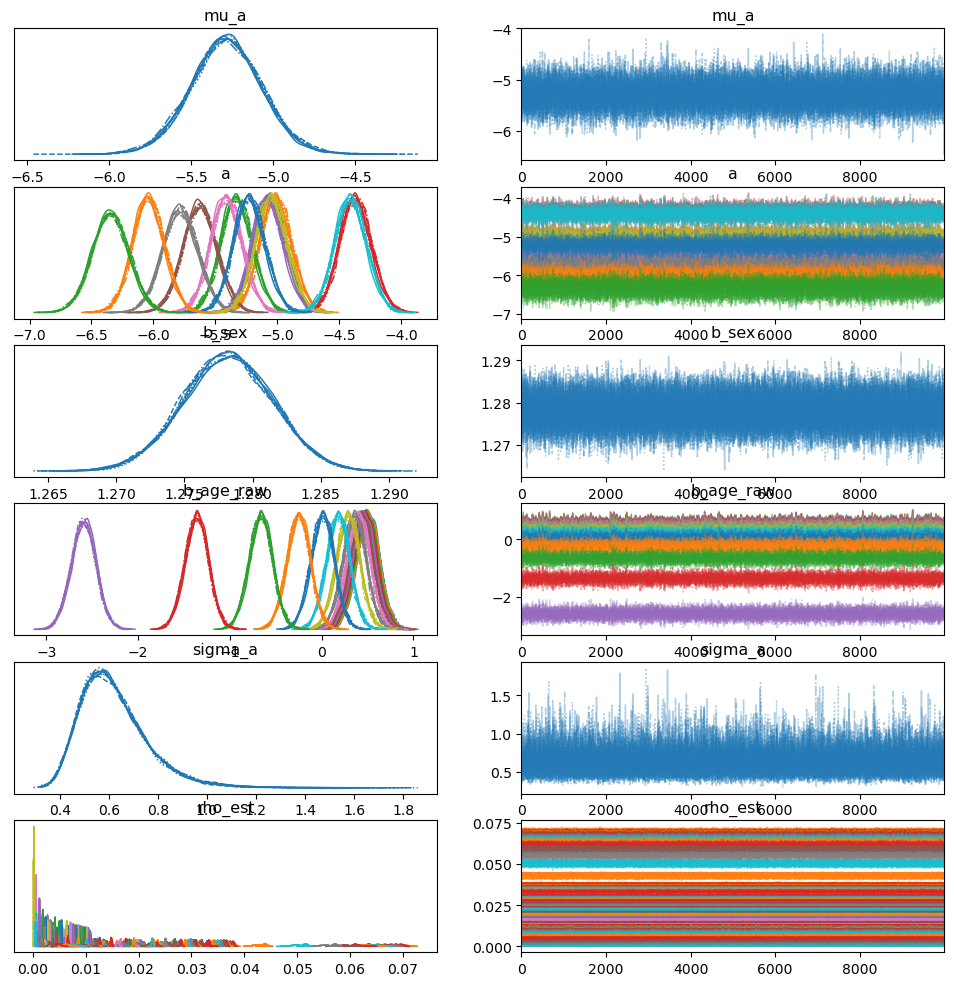

In [15]:
# assuming 'trace' is the result of an MCMC run
az.plot_trace(trace, compact=True)

C:\Users\Admin\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (3368) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_a\n0'}>,
        <Axes: title={'center': 'mu_a\n1'}>,
        <Axes: title={'center': 'mu_a\n2'}>,
        <Axes: title={'center': 'mu_a\n3'}>],
       [<Axes: title={'center': 'mu_a\n4'}>,
        <Axes: title={'center': 'mu_a\n5'}>,
        <Axes: title={'center': 'mu_a\n6'}>,
        <Axes: title={'center': 'mu_a\n7'}>],
       [<Axes: title={'center': 'a\n0, 0'}>,
        <Axes: title={'center': 'a\n0, 1'}>,
        <Axes: title={'center': 'a\n0, 2'}>,
        <Axes: title={'center': 'a\n0, 3'}>],
       [<Axes: title={'center': 'a\n0, 4'}>,
        <Axes: title={'center': 'a\n0, 5'}>,
        <Axes: title={'center': 'a\n0, 6'}>,
        <Axes: title={'center': 'a\n0, 7'}>],
       [<Axes: title={'center': 'a\n0, 8'}>,
        <Axes: title={'center': 'a\n0, 9'}>,
        <Axes: title={'center': 'a\n0, 10'}>,
        <Axes: title={'center': 'a\n0, 11'}>],
       [<Axes: title={'center': 'a\n0, 12'}>,
        <Axes: title={'center': 'a\n1, 0'}>,
  

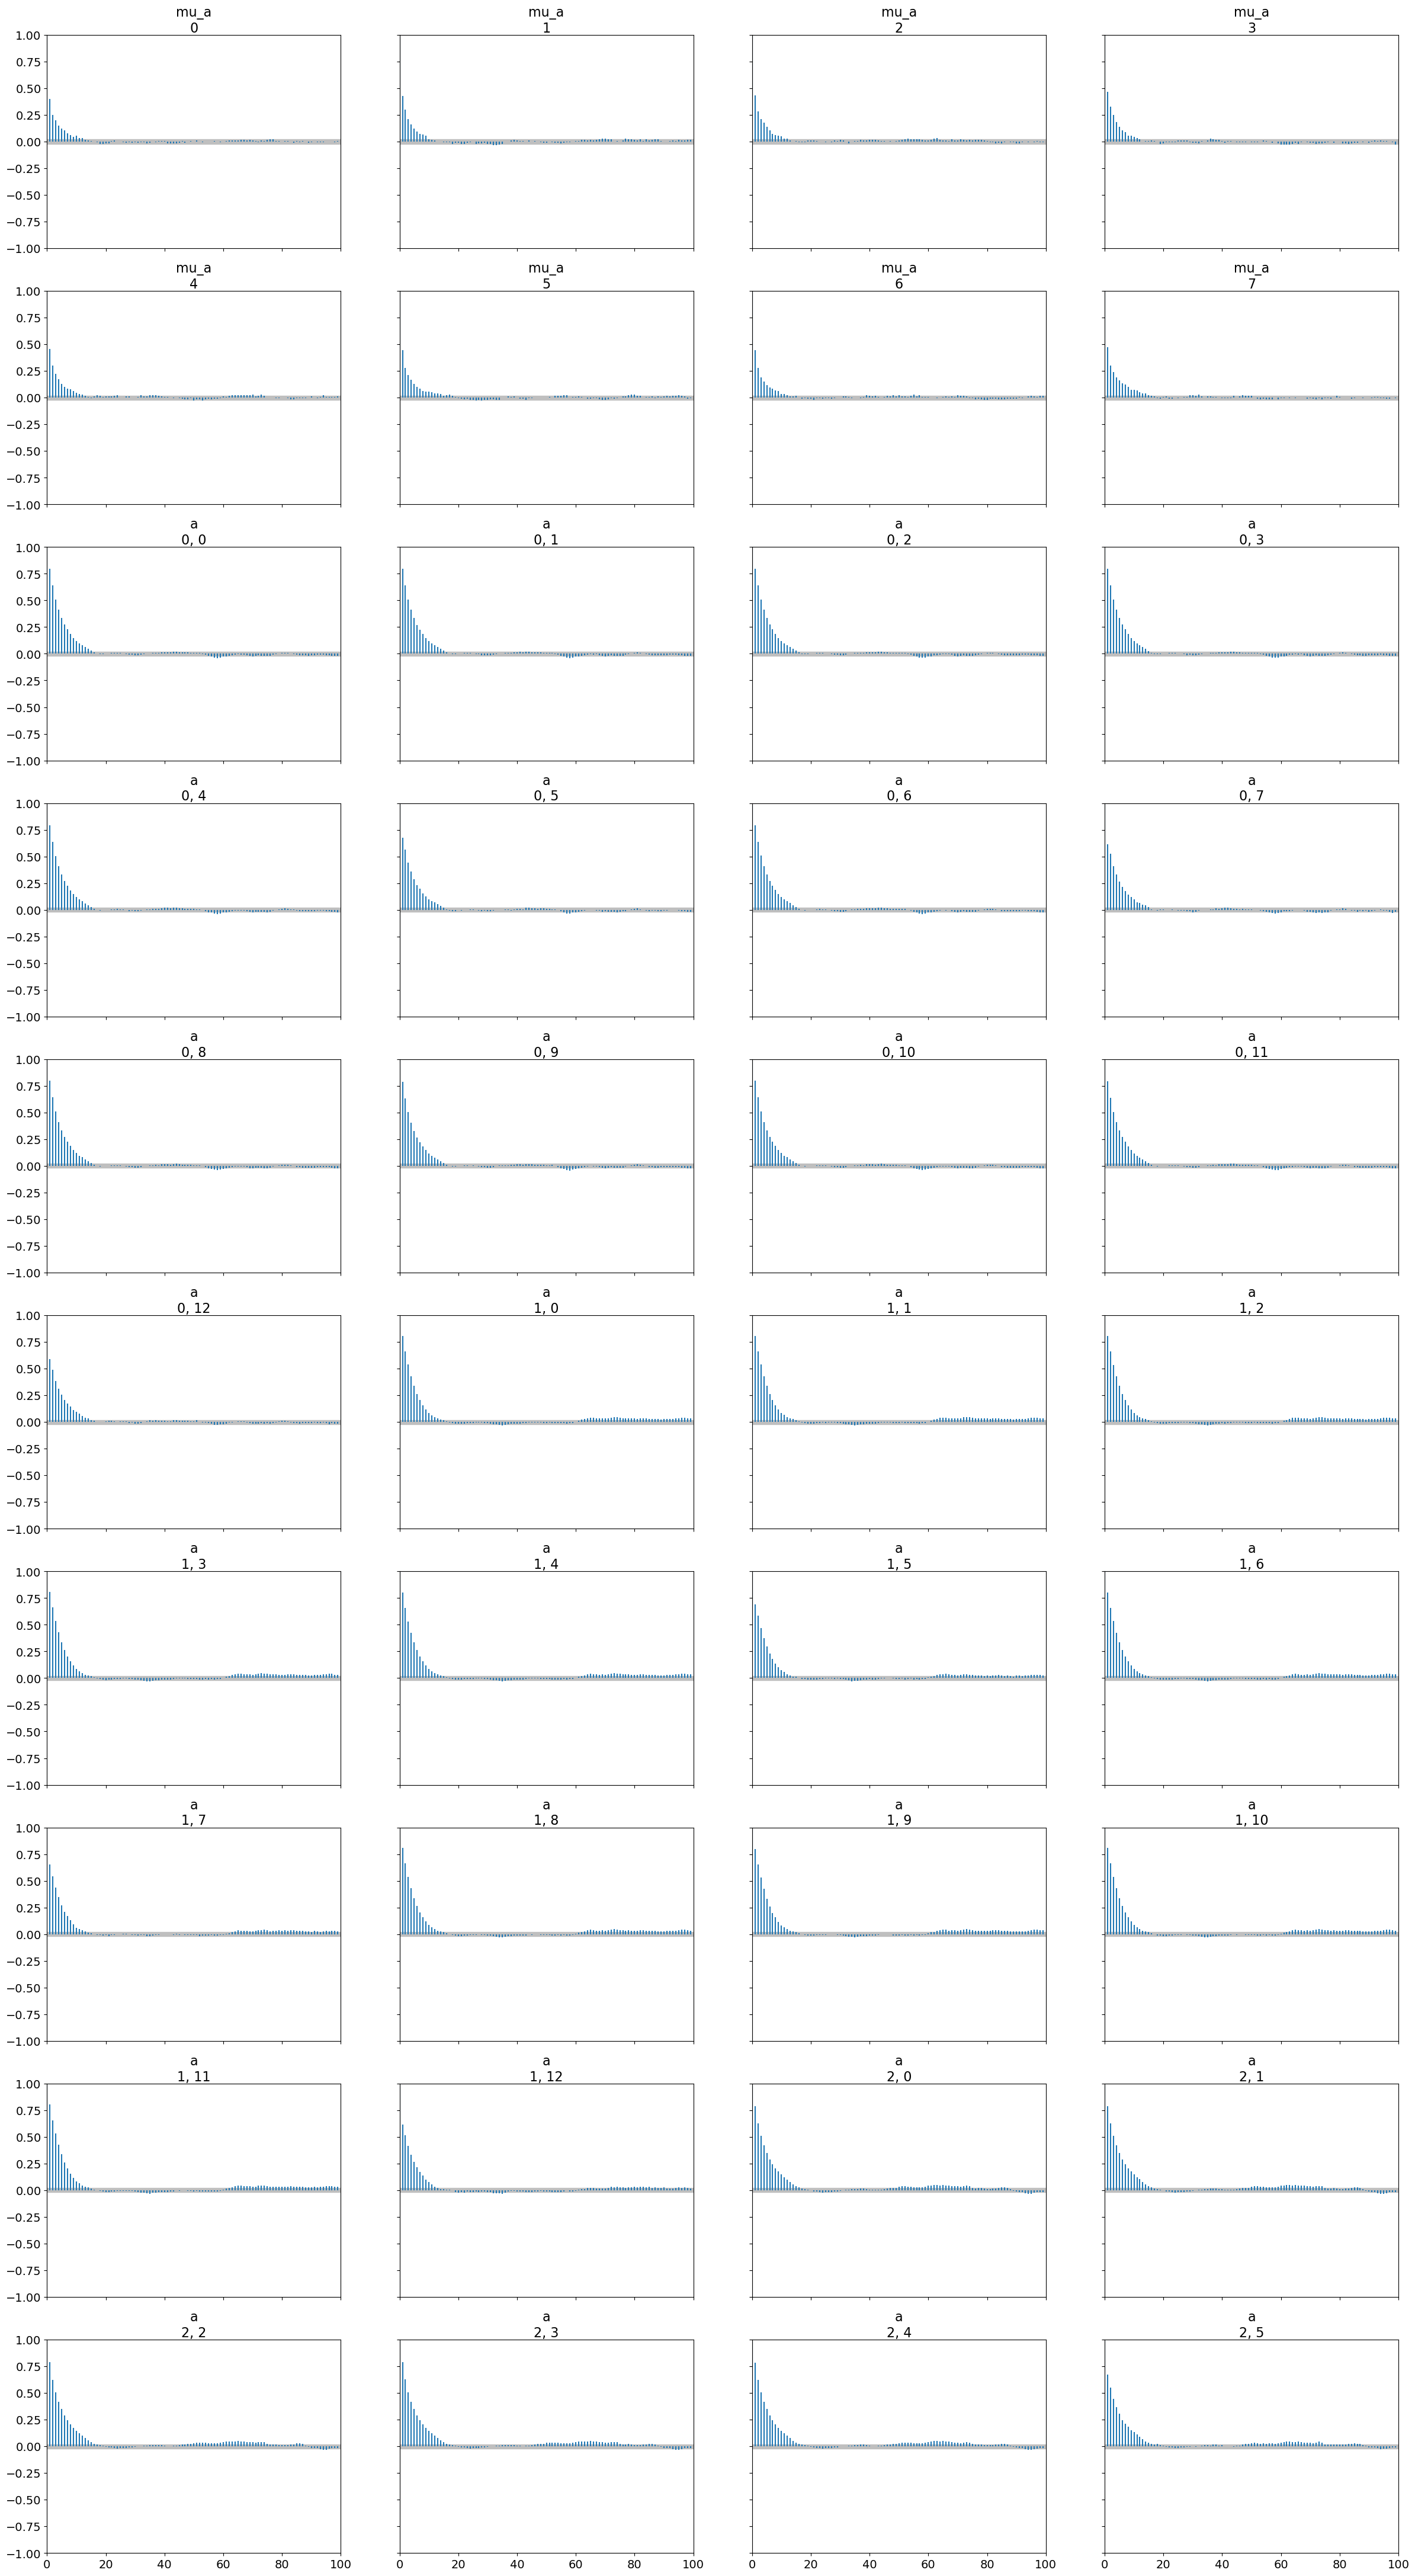

In [16]:
# assuming 'trace' is the result of an MCMC run
az.plot_autocorr(trace)

Sampling: [y_like]


<Axes: xlabel='y_like / y_like'>

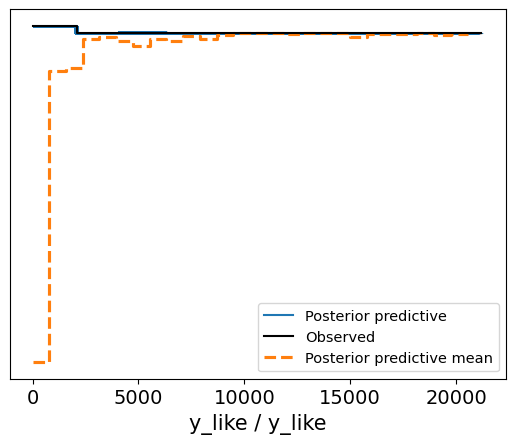

In [17]:
posterior = pm.sample_posterior_predictive(trace, model=hierarchical_model, return_inferencedata=True)
az.plot_ppc(posterior)